In [1]:
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import torch
import torch.nn.functional as F
from pytorch_grad_cam import GradCAM
from segmentation_models_pytorch.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU
from segmentation_models_pytorch.utils.train import TrainEpoch, ValidEpoch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from model.substation.config import *
from model.substation.retrain_with_xai import SubstationDataset, get_training_augmentation, get_preprocessing, \
    get_validation_augmentation
from utils import DEVICE
from model.substation.retrain_with_xai import EarlyStopping

In [2]:
%env PYTHONPATH="/home/r6639/Projects/xaiseg":$PYTHONPATH

env: PYTHONPATH="/home/r6639/Projects/xaiseg":$PYTHONPATH


In [3]:
num_classes = len(CLASSES)

In [4]:
def compute_gradcam_heatmap(model, target_layer, input_tensor, masks):
    # input_tensor.requires_grad = True  # Already set in the forward method
    cam = GradCAM(model=model, target_layers=[target_layer])

    targets = []
    for i in range(input_tensor.size(0)):
        target = SemanticSegmentationTarget(category=None, mask=masks[i])
        targets.append(target)

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    return grayscale_cam

In [5]:
def get_activation(model, target_layer, x):
    activations = []

    def hook(module, input, output):
        activations.append(output)

    handle = target_layer.register_forward_hook(hook)
    _ = model(x)
    handle.remove()
    return activations[0]

In [6]:
def normalize_heatmap(heatmap):
    # Compute the minimum and maximum values along the specified dimensions
    heatmap_min = heatmap.min(dim=1, keepdim=True)[0].min(dim=2, keepdim=True)[0]
    heatmap_max = heatmap.max(dim=1, keepdim=True)[0].max(dim=2, keepdim=True)[0]

    # Normalize the heatmap using broadcasting
    normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + 1e-8)
    return normalized_heatmap

In [7]:
class EarlyStopping:
    def __init__(self, optimizer, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.optimizer = optimizer

    def __call__(self, val_loss, model, path_name):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path_name)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter == 5:
                self.optimizer.param_groups[0]['lr'] = 1e-5
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path_name)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path_name):
        """Saves model when validation loss decrease."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path_name)
        self.val_loss_min = val_loss

In [8]:
class GradCAMDistillationLoss(torch.nn.Module):
    def __init__(self, student_loss_fn, teacher_model, student_model, distillation_weight):
        super(GradCAMDistillationLoss, self).__init__()
        self.student_loss_fn = student_loss_fn
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.distillation_weight = distillation_weight

    def forward(self, student_output, y_true, x_tensor):
        # Ensure x_tensor requires gradients
        x_tensor.requires_grad = True

        # Compute the student's segmentation loss
        student_loss = self.student_loss_fn(student_output, y_true)

        # Set models to eval mode for Grad-CAM computation
        self.teacher_model.eval()
        self.student_model.eval()

        # Ensure teacher model parameters require gradients
        for param in self.teacher_model.parameters():
            param.requires_grad = True

        # Obtain masks for each input (teacher predictions)
        # Do not use torch.no_grad() here
        teacher_preds = self.teacher_model(x_tensor)
        teacher_masks = torch.argmax(teacher_preds, dim=1, keepdim=True).float()
        teacher_masks = teacher_masks.squeeze(1)

        # Student masks (student predictions)
        student_masks = torch.argmax(student_output, dim=1, keepdim=True).float()
        student_masks = student_masks.squeeze(1)

        # Compute Grad-CAM heatmap for the teacher model
        teacher_heatmap = compute_gradcam_heatmap(
            model=teacher_model,
            target_layer=self.teacher_model.decoder.block1,
            input_tensor=x_tensor,
            masks=teacher_masks
        )
        student_heatmap = compute_gradcam_heatmap(
            model=self.student_model,
            target_layer=self.student_model.decoder.block1,
            input_tensor=x_tensor,
            masks=student_masks
        )

        # Convert heatmaps to torch tensors and move to device
        teacher_heatmap = torch.from_numpy(teacher_heatmap).float().to(student_output.device)
        student_heatmap = torch.from_numpy(student_heatmap).float().to(student_output.device)

        # Normalize heatmaps
        teacher_heatmap = normalize_heatmap(teacher_heatmap)
        student_heatmap = normalize_heatmap(student_heatmap)

        # Compute distillation loss between heatmaps
        distillation_loss = F.mse_loss(student_heatmap, teacher_heatmap)

        # Combine the losses
        total_loss = (1 - self.distillation_weight) * student_loss + self.distillation_weight * distillation_loss

        # Set models back to train mode
        self.teacher_model.train()
        self.student_model.train()

        return total_loss

In [9]:
class GradCAMDistillationLossAlpha(torch.nn.Module):
    def __init__(self, student_loss_fn, teacher_model, student_model, distillation_weight, soft_label_weight,
                 temperature=1.0):
        super(GradCAMDistillationLossAlpha, self).__init__()
        self.student_loss_fn = student_loss_fn
        self.teacher_model = teacher_model
        self.student_model = student_model
        self.distillation_weight = distillation_weight
        self.soft_label_weight = soft_label_weight
        self.temperature = temperature
        self.kl_div_loss_fn = torch.nn.KLDivLoss(reduction='batchmean')

    def forward(self, student_output, y_true, x_tensor, compute_gradcam=True):
        # Compute the student's segmentation loss
        student_loss = self.student_loss_fn(student_output, y_true)

        # Obtain teacher's outputs (soft labels)
        with torch.no_grad():
            teacher_output = self.teacher_model(x_tensor)

        # Compute the soft label loss (KL Divergence)
        # Apply temperature scaling
        student_logits = student_output / self.temperature
        teacher_logits = teacher_output / self.temperature

        # Compute probabilities
        student_log_probs = F.log_softmax(student_logits, dim=1)
        teacher_probs = F.softmax(teacher_logits, dim=1)

        # Compute KL Divergence
        soft_label_loss = self.kl_div_loss_fn(student_log_probs, teacher_probs) * (self.temperature ** 2)

        distillation_loss = 0.0  # Default value

        if compute_gradcam:
            # Ensure x_tensor requires gradients
            x_tensor.requires_grad = True

            # Compute Grad-CAM heatmaps
            # Student masks (student predictions)
            student_masks = torch.argmax(student_output, dim=1).float()

            # Teacher masks (teacher predictions)
            teacher_masks = torch.argmax(teacher_output, dim=1).float()

            # Compute Grad-CAM heatmaps for teacher and student
            teacher_heatmap = compute_gradcam_heatmap(
                model=self.teacher_model,
                target_layer=self.teacher_model.decoder.block1,
                input_tensor=x_tensor,
                masks=teacher_masks
            )
            student_heatmap = compute_gradcam_heatmap(
                model=self.student_model,
                target_layer=self.student_model.decoder.block1,
                input_tensor=x_tensor,
                masks=student_masks
            )

            # Convert heatmaps to torch tensors and move to device
            teacher_heatmap = torch.from_numpy(teacher_heatmap).float().to(student_output.device)
            student_heatmap = torch.from_numpy(student_heatmap).float().to(student_output.device)

            # Normalize heatmaps
            teacher_heatmap = normalize_heatmap(teacher_heatmap)
            student_heatmap = normalize_heatmap(student_heatmap)

            # Compute distillation loss between heatmaps
            distillation_loss = F.mse_loss(student_heatmap, teacher_heatmap)

        # Combine the losses
        total_loss = (
                student_loss
                + self.soft_label_weight * soft_label_loss
                + self.distillation_weight * distillation_loss
        )

        return total_loss


In [10]:
class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        # Ensure mask is a torch tensor
        if isinstance(mask, np.ndarray):
            self.mask = torch.from_numpy(mask).float()
        else:
            self.mask = mask.float()
        if torch.cuda.is_available():
            self.mask = self.mask.cuda()

    def __call__(self, model_output):
        # model_output shape: (C, H, W)
        if self.category is not None:
            output = model_output[self.category, :, :]
        else:
            output = model_output.sum(dim=0)
        loss = (output * self.mask).sum()
        # Add epsilon to prevent zero gradients
        loss += 1e-6
        return loss

In [11]:
class NamedDiceLoss(DiceLoss):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__name__ = "DiceLoss"

In [12]:
def evaluate_model(model, dataloader):
    model.eval()
    test_loss = 0
    test_iou = 0
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Get predictions
            output = model(x_batch)

            # Compute loss (use DiceLoss for evaluation)
            loss = DiceLoss(mode='multiclass')(output, y_batch)

            # Accumulate metrics
            test_loss += loss.item()
            y_pred = torch.argmax(output, dim=1)
            y_true = torch.argmax(y_batch, dim=1)
            iou = IoU()(y_pred, y_true)
            test_iou += iou.item()

    # Compute average loss and IoU
    test_loss /= len(dataloader)
    test_iou /= len(dataloader)

    return test_loss, test_iou

In [159]:
teacher_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATIONS
)
teacher_model.to(DEVICE)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [16]:
# Define preprocessing function
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [131]:
# Create training and validation datasets
train_dataset = SubstationDataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation(),
                                  preprocessing=get_preprocessing(preprocessing_fn))

val_dataset = SubstationDataset(x_val_dir, y_val_dir, augmentation=get_validation_augmentation(),
                                preprocessing=get_preprocessing(preprocessing_fn))

test_dataset = SubstationDataset(x_test_dir, y_test_dir, augmentation=get_validation_augmentation(),
                                 preprocessing=get_preprocessing(preprocessing_fn))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

In [ ]:
# Define loss function, metrics, and optimizer for the teacher model
teacher_loss_fn = NamedDiceLoss(mode='multiclass')
metrics = [IoU(threshold=0.5)]
teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.0001)
# Early Stopping Initialization
early_stopping = EarlyStopping(optimizer=teacher_optimizer, patience=15, verbose=True)
# Training loop for the teacher model
for epoch in range(EPOCHS):
    print(f'\nEpoch: {epoch}')
    teacher_model.train()
    train_loss = 0
    train_iou = 0

    for x_batch, y_batch in tqdm(train_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)

        # Get teacher predictions
        teacher_output = teacher_model(x_batch)

        # Compute the loss for the teacher model
        loss = teacher_loss_fn(teacher_output, y_batch)

        # Backpropagation and optimization
        teacher_optimizer.zero_grad()
        loss.backward()
        teacher_optimizer.step()

        # Accumulate metrics
        train_loss += loss.item()
        # Compute IoU for the batch
        y_pred = torch.argmax(teacher_output, dim=1)
        y_true = torch.argmax(y_batch, dim=1)
        iou = IoU()(y_pred, y_true)
        train_iou += iou.item()

    # Compute average training loss and IoU
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validation
    teacher_model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Get teacher predictions
            teacher_output = teacher_model(x_batch)

            # Compute the validation loss
            loss = teacher_loss_fn(teacher_output, y_batch)

            # Accumulate metrics
            val_loss += loss.item()
            y_pred = torch.argmax(teacher_output, dim=1)
            y_true = torch.argmax(y_batch, dim=1)
            iou = IoU()(y_pred, y_true)
            val_iou += iou.item()

    # Compute average validation loss and IoU
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    print(
        f'Epoch {epoch} - Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

    # Early Stopping
    early_stopping(val_loss, teacher_model, 'teacher_model.pth')
    if early_stopping.early_stop:
        print("Early stopping")
        break

In [ ]:
# Training loop
max_score = 0
train_loss_log = []
train_iou_log = []
val_loss_log = []
val_iou_log = []

for epoch in range(EPOCHS):
    print(f'\nEpoch: {epoch}')
    train_logs = train_epoch.run(train_loader)
    train_loss_log.append(train_logs['DiceLoss'])
    train_iou_log.append(train_logs['iou_score'])

    valid_logs = valid_epoch.run(val_loader)
    val_loss_log.append(valid_logs['DiceLoss'])
    val_iou_log.append(valid_logs['iou_score'])

    # Early Stopping
    early_stopping(valid_logs['DiceLoss'], teacher_model, 'teacher_model.pth')
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Save the logs for future use
np.save('train_loss_log_aug_xai_reg.npy', train_loss_log)
np.save('train_iou_log_aug_xai_reg.npy', train_iou_log)
np.save('val_loss_log_aug_xai_reg.npy', val_loss_log)
np.save('val_iou_log_aug_xai_reg.npy', val_iou_log)
print(f'Train IOU: {train_iou_log}, Val IOU: {val_iou_log}')

In [119]:
# Load the trained teacher model
teacher_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATIONS
)
teacher_model.load_state_dict(torch.load('teacher_model.pth'))
teacher_model.to(DEVICE)
teacher_model.eval()  # Set teacher model to evaluation mode

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

In [118]:
# Initialize the student model
ENCODER_STUDENT = 'resnet18'
student_model = smp.DeepLabV3Plus(
    encoder_name=ENCODER_STUDENT,
    encoder_weights=ENCODER_WEIGHTS,  # You can set this to None if you want to train from scratch
    classes=len(CLASSES),
    activation=ACTIVATIONS
)
student_model.to(DEVICE)

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=Tr

In [107]:
# Define the student's segmentation loss function
student_loss_fn = NamedDiceLoss(mode='multiclass')

# Define the GradCAM distillation loss function
distillation_weight = 0.7  # Adjust as needed

distillation_loss_fn = GradCAMDistillationLoss(
    student_loss_fn=student_loss_fn,
    teacher_model=teacher_model,
    student_model=student_model,
    distillation_weight=distillation_weight
)

# Define optimizer and metrics for the student model
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0001)
metrics = [IoU(threshold=0.5)]
# Early Stopping Initialization
early_stopping = EarlyStopping(optimizer=optimizer, patience=15, verbose=True)

In [108]:
# Training loop for the student model with GradCAM distillation
max_score = 0
print("Distillation Weight:", distillation_weight)
for epoch in range(EPOCHS):
    print(f'\nEpoch: {epoch}')
    student_model.train()
    train_loss = 0
    train_iou = 0

    for x_batch, y_batch in tqdm(train_loader):
        x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

        # Get student predictions
        student_output = student_model(x_batch)

        # Compute the distillation loss
        loss = distillation_loss_fn(student_output, y_batch, x_batch)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate metrics
        train_loss += loss.item()
        # Compute IoU for the batch
        y_pred = torch.argmax(student_output, dim=1)
        y_true = torch.argmax(y_batch, dim=1)
        iou = IoU()(y_pred, y_true)
        train_iou += iou.item()

    # Compute average loss and IoU
    train_loss /= len(train_loader)
    train_iou /= len(train_loader)

    # Validation
    student_model.eval()
    val_loss = 0
    val_iou = 0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)

            # Get student predictions
            student_output = student_model(x_batch)

            # Compute the student's segmentation loss
            loss = student_loss_fn(student_output, y_batch)

            # Accumulate metrics
            val_loss += loss.item()
            y_pred = torch.argmax(student_output, dim=1)
            y_true = torch.argmax(y_batch, dim=1)
            iou = IoU()(y_pred, y_true)
            val_iou += iou.item()

    # Compute average validation loss and IoU
    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    print(
        f'Epoch {epoch} - Train Loss: {train_loss:.4f}, Train IoU: {train_iou:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

    # Early Stopping
    early_stopping(val_loss, student_model, 'student_model_07.pth')
    if early_stopping.early_stop:
        print("Early stopping")
        break

Distillation Weight: 0.7

Epoch: 0


100%|██████████| 150/150 [00:15<00:00,  9.59it/s]


Epoch 0 - Train Loss: 0.2577, Train IoU: 0.0000, Val Loss: 0.3364, Val IoU: 0.0902
Validation loss decreased (inf --> 0.336357).  Saving model ...

Epoch: 1


100%|██████████| 150/150 [00:15<00:00,  9.52it/s]


Epoch 1 - Train Loss: 0.2599, Train IoU: 0.0000, Val Loss: 0.3362, Val IoU: 0.0977
Validation loss decreased (0.336357 --> 0.336176).  Saving model ...

Epoch: 2


100%|██████████| 150/150 [00:15<00:00,  9.57it/s]


Epoch 2 - Train Loss: 0.2583, Train IoU: 0.0000, Val Loss: 0.3362, Val IoU: 0.0827
EarlyStopping counter: 1 out of 15

Epoch: 3


100%|██████████| 150/150 [00:14<00:00, 10.01it/s]


Epoch 3 - Train Loss: 0.2601, Train IoU: 0.0000, Val Loss: 0.3361, Val IoU: 0.0376
Validation loss decreased (0.336176 --> 0.336102).  Saving model ...

Epoch: 4


100%|██████████| 150/150 [00:15<00:00,  9.59it/s]


Epoch 4 - Train Loss: 0.2601, Train IoU: 0.0000, Val Loss: 0.3359, Val IoU: 0.0602
Validation loss decreased (0.336102 --> 0.335943).  Saving model ...

Epoch: 5


100%|██████████| 150/150 [00:16<00:00,  9.05it/s]


Epoch 5 - Train Loss: 0.2606, Train IoU: 0.0000, Val Loss: 0.3358, Val IoU: 0.0451
Validation loss decreased (0.335943 --> 0.335818).  Saving model ...

Epoch: 6


100%|██████████| 150/150 [00:16<00:00,  9.25it/s]


Epoch 6 - Train Loss: 0.2595, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
Validation loss decreased (0.335818 --> 0.335719).  Saving model ...

Epoch: 7


100%|██████████| 150/150 [00:15<00:00,  9.63it/s]


Epoch 7 - Train Loss: 0.2599, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
Validation loss decreased (0.335719 --> 0.335700).  Saving model ...

Epoch: 8


100%|██████████| 150/150 [00:16<00:00,  9.23it/s]


Epoch 8 - Train Loss: 0.2573, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
EarlyStopping counter: 1 out of 15

Epoch: 9


100%|██████████| 150/150 [00:16<00:00,  9.36it/s]


Epoch 9 - Train Loss: 0.2595, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0451
EarlyStopping counter: 2 out of 15

Epoch: 10


100%|██████████| 150/150 [00:16<00:00,  9.25it/s]


Epoch 10 - Train Loss: 0.2565, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0602
EarlyStopping counter: 3 out of 15

Epoch: 11


100%|██████████| 150/150 [00:15<00:00,  9.59it/s]


Epoch 11 - Train Loss: 0.2609, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 4 out of 15

Epoch: 12


100%|██████████| 150/150 [00:16<00:00,  9.07it/s]


Epoch 12 - Train Loss: 0.2601, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0602
EarlyStopping counter: 5 out of 15

Epoch: 13


100%|██████████| 150/150 [00:17<00:00,  8.69it/s]


Epoch 13 - Train Loss: 0.2585, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 6 out of 15

Epoch: 14


100%|██████████| 150/150 [00:16<00:00,  9.12it/s]


Epoch 14 - Train Loss: 0.2584, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
Validation loss decreased (0.335700 --> 0.335690).  Saving model ...

Epoch: 15


100%|██████████| 150/150 [00:16<00:00,  9.33it/s]


Epoch 15 - Train Loss: 0.2546, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 1 out of 15

Epoch: 16


100%|██████████| 150/150 [00:15<00:00,  9.55it/s]


Epoch 16 - Train Loss: 0.2568, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 2 out of 15

Epoch: 17


100%|██████████| 150/150 [00:16<00:00,  9.19it/s]


Epoch 17 - Train Loss: 0.2583, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
EarlyStopping counter: 3 out of 15

Epoch: 18


100%|██████████| 150/150 [00:15<00:00,  9.44it/s]


Epoch 18 - Train Loss: 0.2583, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 4 out of 15

Epoch: 19


100%|██████████| 150/150 [00:16<00:00,  9.11it/s]


Epoch 19 - Train Loss: 0.2590, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
Validation loss decreased (0.335690 --> 0.335682).  Saving model ...

Epoch: 20


100%|██████████| 150/150 [00:16<00:00,  9.18it/s]


Epoch 20 - Train Loss: 0.2567, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
EarlyStopping counter: 1 out of 15

Epoch: 21


100%|██████████| 150/150 [00:17<00:00,  8.60it/s]


Epoch 21 - Train Loss: 0.2585, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 2 out of 15

Epoch: 22


100%|██████████| 150/150 [00:15<00:00,  9.51it/s]


Epoch 22 - Train Loss: 0.2595, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 3 out of 15

Epoch: 23


100%|██████████| 150/150 [00:13<00:00, 10.93it/s]


Epoch 23 - Train Loss: 0.2595, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 4 out of 15

Epoch: 24


100%|██████████| 150/150 [00:15<00:00,  9.43it/s]


Epoch 24 - Train Loss: 0.2600, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0526
EarlyStopping counter: 5 out of 15

Epoch: 25


100%|██████████| 150/150 [00:16<00:00,  9.33it/s]


Epoch 25 - Train Loss: 0.2597, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 6 out of 15

Epoch: 26


100%|██████████| 150/150 [00:15<00:00,  9.39it/s]


Epoch 26 - Train Loss: 0.2582, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 7 out of 15

Epoch: 27


100%|██████████| 150/150 [00:15<00:00,  9.59it/s]


Epoch 27 - Train Loss: 0.2561, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 8 out of 15

Epoch: 28


100%|██████████| 150/150 [00:16<00:00,  9.27it/s]


Epoch 28 - Train Loss: 0.2574, Train IoU: 0.0000, Val Loss: 0.3358, Val IoU: 0.0827
EarlyStopping counter: 9 out of 15

Epoch: 29


100%|██████████| 150/150 [00:15<00:00,  9.48it/s]


Epoch 29 - Train Loss: 0.2567, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0752
EarlyStopping counter: 10 out of 15

Epoch: 30


100%|██████████| 150/150 [00:16<00:00,  9.22it/s]


Epoch 30 - Train Loss: 0.2601, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 11 out of 15

Epoch: 31


100%|██████████| 150/150 [00:16<00:00,  9.36it/s]


Epoch 31 - Train Loss: 0.2584, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0677
EarlyStopping counter: 12 out of 15

Epoch: 32


100%|██████████| 150/150 [00:16<00:00,  9.28it/s]


Epoch 32 - Train Loss: 0.2583, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0827
EarlyStopping counter: 13 out of 15

Epoch: 33


100%|██████████| 150/150 [00:16<00:00,  9.01it/s]


Epoch 33 - Train Loss: 0.2575, Train IoU: 0.0000, Val Loss: 0.3358, Val IoU: 0.0827
EarlyStopping counter: 14 out of 15

Epoch: 34


100%|██████████| 150/150 [00:15<00:00,  9.61it/s]


Epoch 34 - Train Loss: 0.2589, Train IoU: 0.0000, Val Loss: 0.3357, Val IoU: 0.0602
EarlyStopping counter: 15 out of 15
Early stopping


## Training the Student Model with Distillation Loss

In [ ]:
# Define the student's segmentation loss function
student_loss_fn = NamedDiceLoss(mode='multiclass')

# Define optimizer and metrics for the student model
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0001)
metrics = [IoU(threshold=0.5)]
# Early Stopping Initialization
early_stopping = EarlyStopping(optimizer=optimizer, patience=15, verbose=True)

# Set teacher model to evaluation mode and prevent training updates
teacher_model.eval()
for param in teacher_model.parameters():
    param.requires_grad = False  # Ensure teacher model's parameters are not updated

# Initialize the custom distillation loss
distillation_loss_alpha_fn = GradCAMDistillationLossAlpha(
    student_loss_fn=student_loss_fn,
    teacher_model=teacher_model,
    student_model=student_model,
    distillation_weight=1,  # Adjust as needed
    soft_label_weight=1,  # Adjust as needed
    temperature=2.0  # Adjust as needed for soft label loss
)

# Training loop
for epoch in range(EPOCHS):
    student_model.train()  # Set student model to training mode
    training_loss = 0.0
    training_iou = 0.0

    for x_batch, y_batch in tqdm(train_loader):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE).squeeze(1)

        # Forward pass for the student model
        student_output = student_model(x_batch)

        # Compute the total loss (including Grad-CAM loss)
        loss = distillation_loss_fn(student_output, y_batch, x_batch)

        # Zero the gradients, backpropagate, and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss for monitoring
        training_loss += loss.item()

        # Compute IoU for the batch
        y_pred = torch.argmax(student_output, dim=1)
        iou = IoU()(y_pred, y_batch)
        training_iou += iou.item()

    training_loss /= len(train_loader)
    training_iou /= len(train_loader)

    # Validation loop
    student_model.eval()  # Set student model to evaluation mode
    val_loss = 0.0
    val_iou = 0.0

    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch = x_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE).squeeze(1)

            # Forward pass for the student model
            student_output = student_model(x_batch)

            # Compute the student's segmentation loss
            loss = student_loss_fn(student_output, y_batch)
            val_loss += loss.item()

            y_pred = torch.argmax(student_output, dim=1)
            iou = IoU()(y_pred, y_batch)
            val_iou += iou.item()

    val_loss /= len(val_loader)
    val_iou /= len(val_loader)

    print(
        f'Epoch {epoch} - Train Loss: {training_loss:.4f}, Train IoU: {training_iou:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

    early_stopping(val_loss, student_model, 'student_model_1_1_2.pth')
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Evaluation

In [18]:
# Initialize the student model
ENCODER_TEACHER = 'resnet101'
teacher_model_base = smp.DeepLabV3Plus(
    encoder_name=ENCODER_TEACHER,
    encoder_weights=ENCODER_WEIGHTS,  # You can set this to None if you want to train from scratch
    classes=len(CLASSES),
    activation=ACTIVATIONS
)

In [19]:
# Initialize the student model
ENCODER_STUDENT = 'resnet18'
student_model_base = smp.DeepLabV3Plus(
    encoder_name=ENCODER_STUDENT,
    encoder_weights=ENCODER_WEIGHTS,  # You can set this to None if you want to train from scratch
    classes=len(CLASSES),
    activation=ACTIVATIONS
)

In [20]:
# Initialize the student model
ENCODER_STUDENT = 'resnet18'
student_model_cam = smp.DeepLabV3Plus(
    encoder_name=ENCODER_STUDENT,
    encoder_weights=ENCODER_WEIGHTS,  # You can set this to None if you want to train from scratch
    classes=len(CLASSES),
    activation=ACTIVATIONS
)

In [21]:
# Function to load the model from a given checkpoint path
def load_model(model, checkpoint_path):
    model.load_state_dict(torch.load(checkpoint_path))
    model.to(DEVICE)
    model.eval()
    return model

In [22]:
# Function to load the model from a given checkpoint path
def load_model_wo_state_dict(model, checkpoint_path):
    model = torch.load(checkpoint_path)
    model.to(DEVICE)
    model.eval()
    return model

In [27]:
# Load the student and teacher models
# student_model_cam = load_model(student_model_cam, 'student_model_1_1_2.pth')
# student_model_no_cam = load_model(student_model_base, 'student_model_0_1_2.pth')
teacher_model = load_model(teacher_model_base, 'teacher_model.pth')
# teacher_model = load_model_wo_state_dict(teacher_model_base, 'model_ResNet101_aug.pth')

## Calculate Performance Metrics

In [13]:
def calculate_iou(model, dataloader, device, classes):
    iou_metric = IoU(threshold=0.5)
    iou_scores = {cls: [] for cls in classes}

    with torch.no_grad():
        for i, (image, gt_mask) in enumerate(dataloader):
            image, gt_mask = image.to(device), gt_mask.to(device)
            pr_mask = model(image).squeeze().cpu().numpy()
            pr_mask = np.argmax(pr_mask, axis=0)

            gt_mask = gt_mask.squeeze().cpu().numpy()

            if pr_mask.shape != gt_mask.shape:
                print(f"Shape mismatch: pr_mask shape {pr_mask.shape}, gt_mask shape {gt_mask.shape}")
                continue

            for idx, cls in enumerate(classes):
                gt_mask_filtered = (gt_mask == idx).astype(float)
                pr_mask_filtered = (pr_mask == idx).astype(float)

                gt_mask_tensor = torch.tensor(gt_mask_filtered, device=device, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                pr_mask_tensor = torch.tensor(pr_mask_filtered, device=device, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

                iou_score = iou_metric(pr_mask_tensor, gt_mask_tensor).item()
                iou_scores[cls].append(iou_score)

    avg_iou_scores = {cls: np.mean(scores) for cls, scores in iou_scores.items()}
    miou = np.mean(list(avg_iou_scores.values()))

    return avg_iou_scores, miou

In [14]:
def evaluate_model_metric(model, dataloader, device, classes, model_name, dataset_name):
    avg_iou_scores, miou = calculate_iou(model, dataloader, device, classes)

    print(f"\nIoU Scores for each category in {dataset_name} using {model_name}:")
    for cls, score in avg_iou_scores.items():
        print(f"{cls}: {score:.4f}")
    print(f"Mean IoU for {dataset_name} using {model_name}: {miou:.4f}\n")

In [17]:
# Datasets and dataloaders
batch_size = 1  # Set batch size to 1 for IoU calculations as in the original code

# Train dataset and dataloader
train_dataset = SubstationDataset(
    x_train_dir,
    y_train_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Validation dataset and dataloader
val_dataset = SubstationDataset(
    x_val_dir,
    y_val_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test dataset and dataloader
test_dataset = SubstationDataset(
    x_test_dir,
    y_test_dir,
    classes=CLASSES,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [28]:
# Evaluate each model on each dataset
models = {
    # "Student Model with Grad-CAM": student_model_cam,
    # "Student Model without Grad-CAM": student_model_no_cam,
    "Teacher Model": teacher_model
}
datasets = {
    "Training Set": train_loader,
    "Validation Set": val_loader,
    "Test Set": test_loader
}

for model_name, model in models.items():
    for dataset_name, loader in datasets.items():
        evaluate_model_metric(model, loader, DEVICE, CLASSES, model_name, dataset_name)


IoU Scores for each category in Training Set using Teacher Model:
breaker: 0.9570
closed_blade_disconnect_switch: 0.6586
closed_tandem_disconnect_switch: 0.8301
current_transformer: 0.5615
fuse_disconnect_switch: 0.9004
glass_disc_insulator: 0.5565
lightning_arrester: 0.6803
muffle: 0.8787
open_blade_disconnect_switch: 0.9464
open_tandem_disconnect_switch: 0.8477
porcelain_pin_insulator: 0.4637
potential_transformer: 0.8469
power_transformer: 0.9372
recloser: 0.8266
tripolar_disconnect_switch: 0.8619
Mean IoU for Training Set using Teacher Model: 0.7836


IoU Scores for each category in Validation Set using Teacher Model:
breaker: 0.9472
closed_blade_disconnect_switch: 0.5074
closed_tandem_disconnect_switch: 0.8571
current_transformer: 0.5414
fuse_disconnect_switch: 0.9023
glass_disc_insulator: 0.5414
lightning_arrester: 0.6015
muffle: 0.8571
open_blade_disconnect_switch: 0.9699
open_tandem_disconnect_switch: 0.9023
porcelain_pin_insulator: 0.3153
potential_transformer: 0.7895
power_t

## Visualizing Results

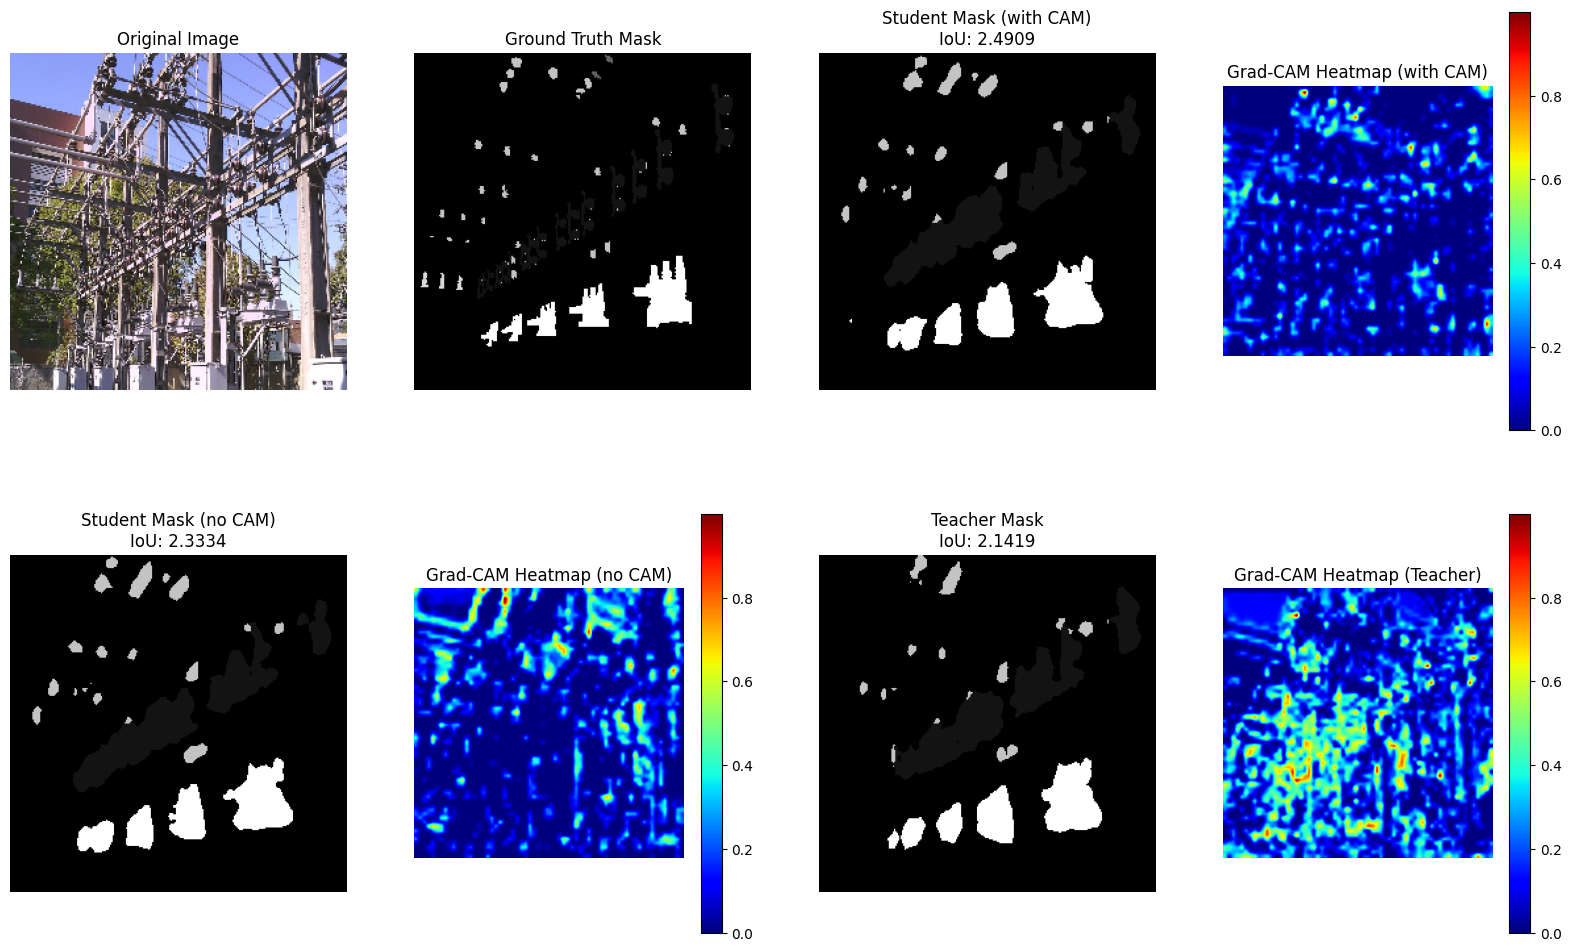

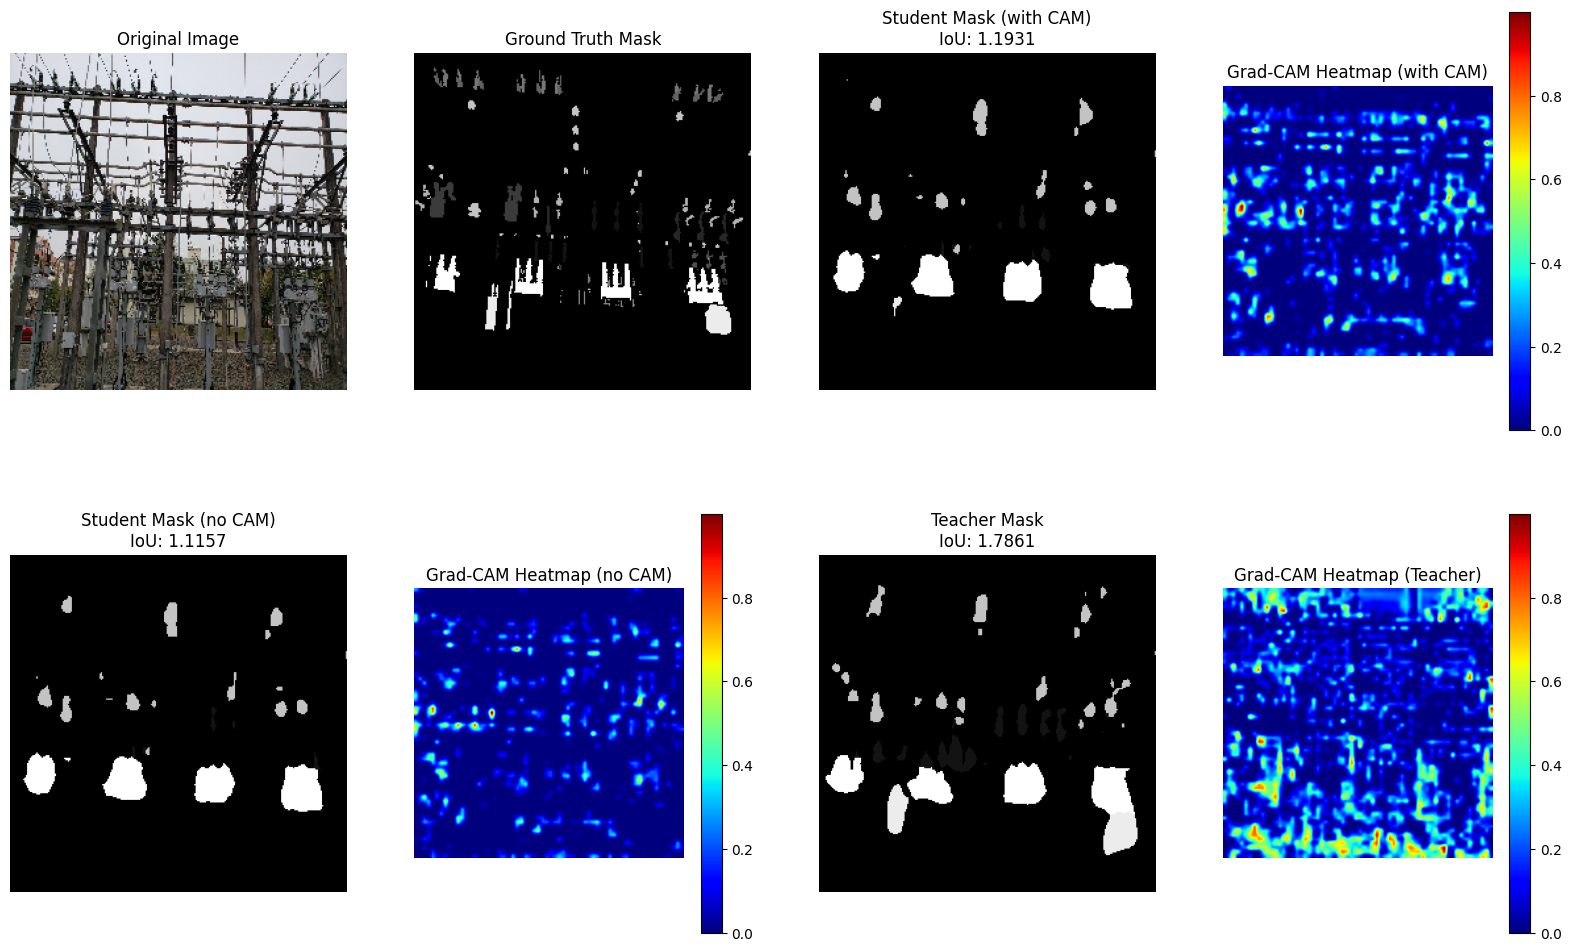

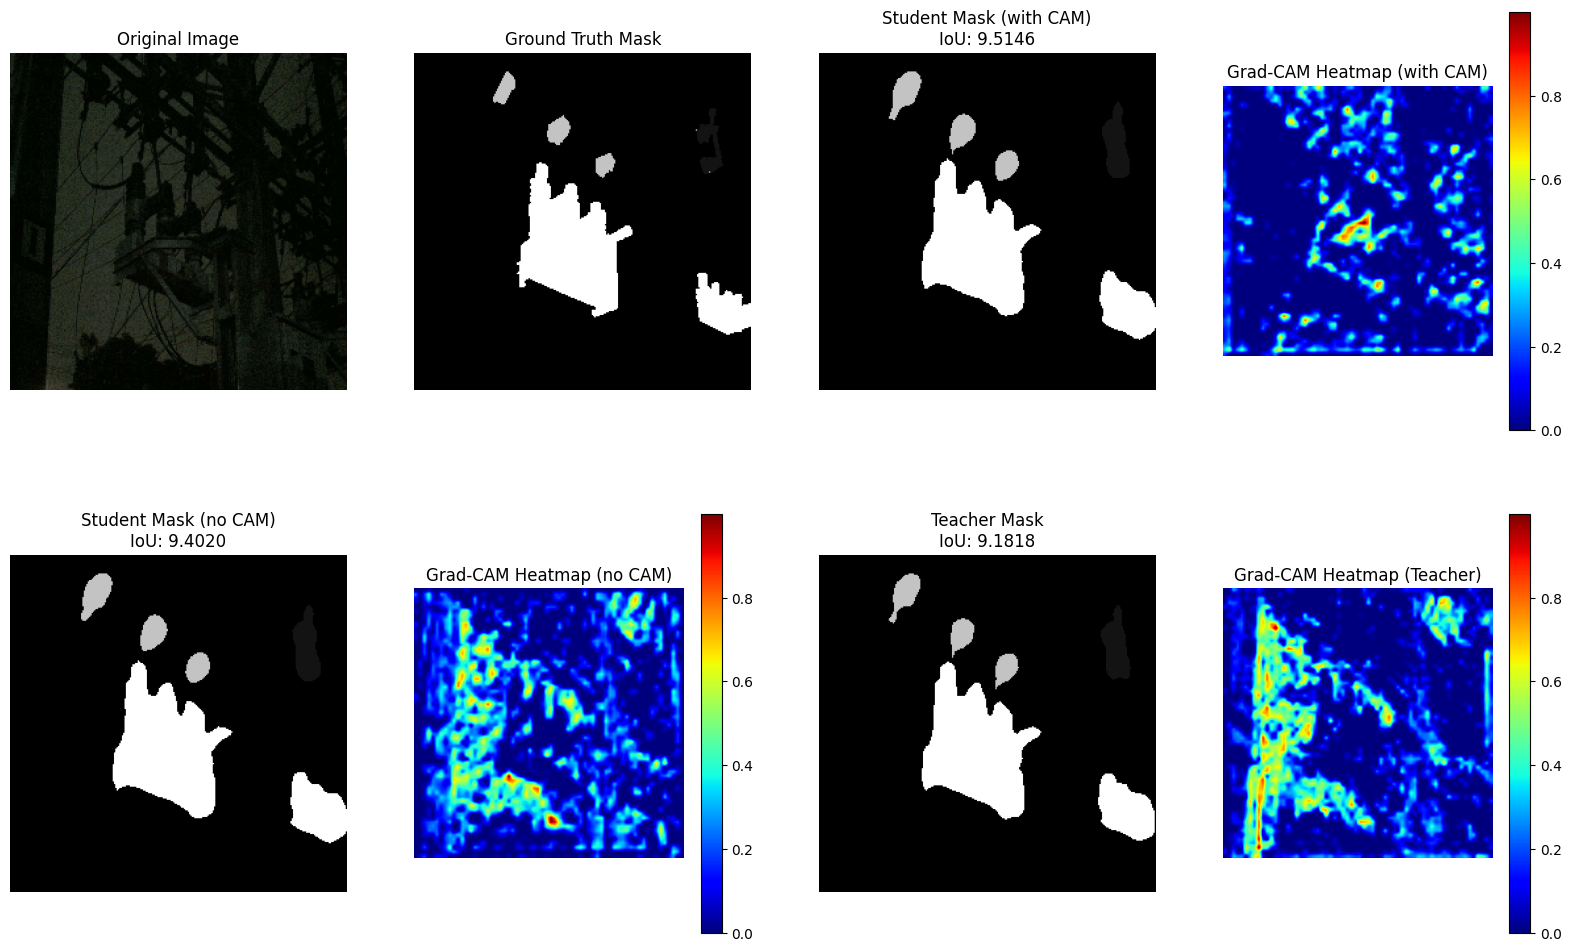

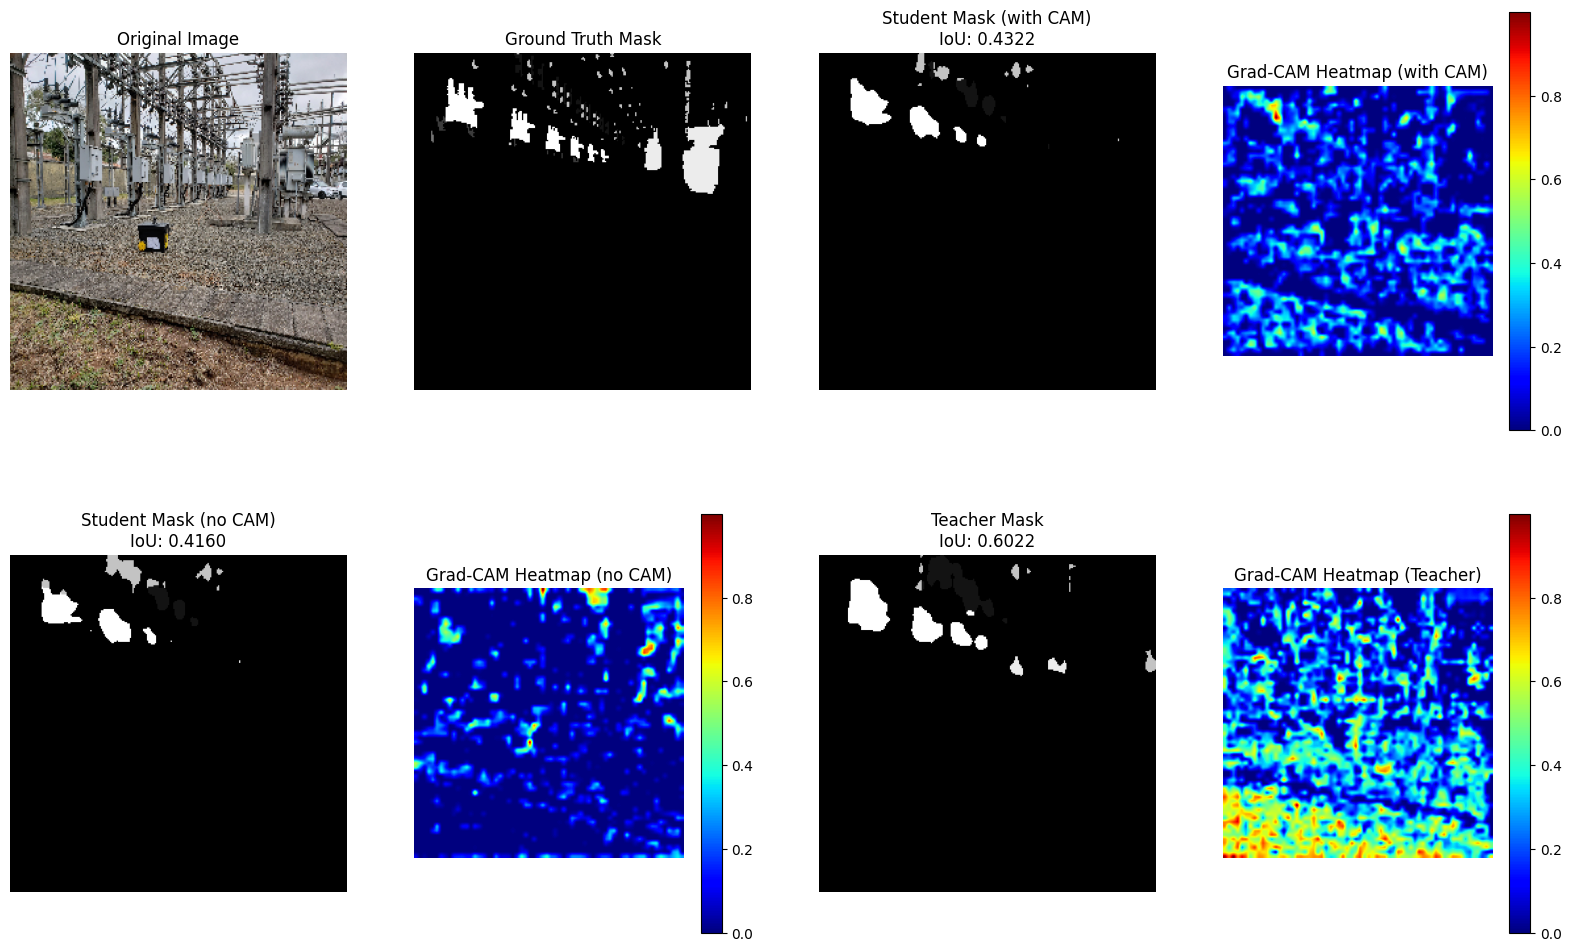

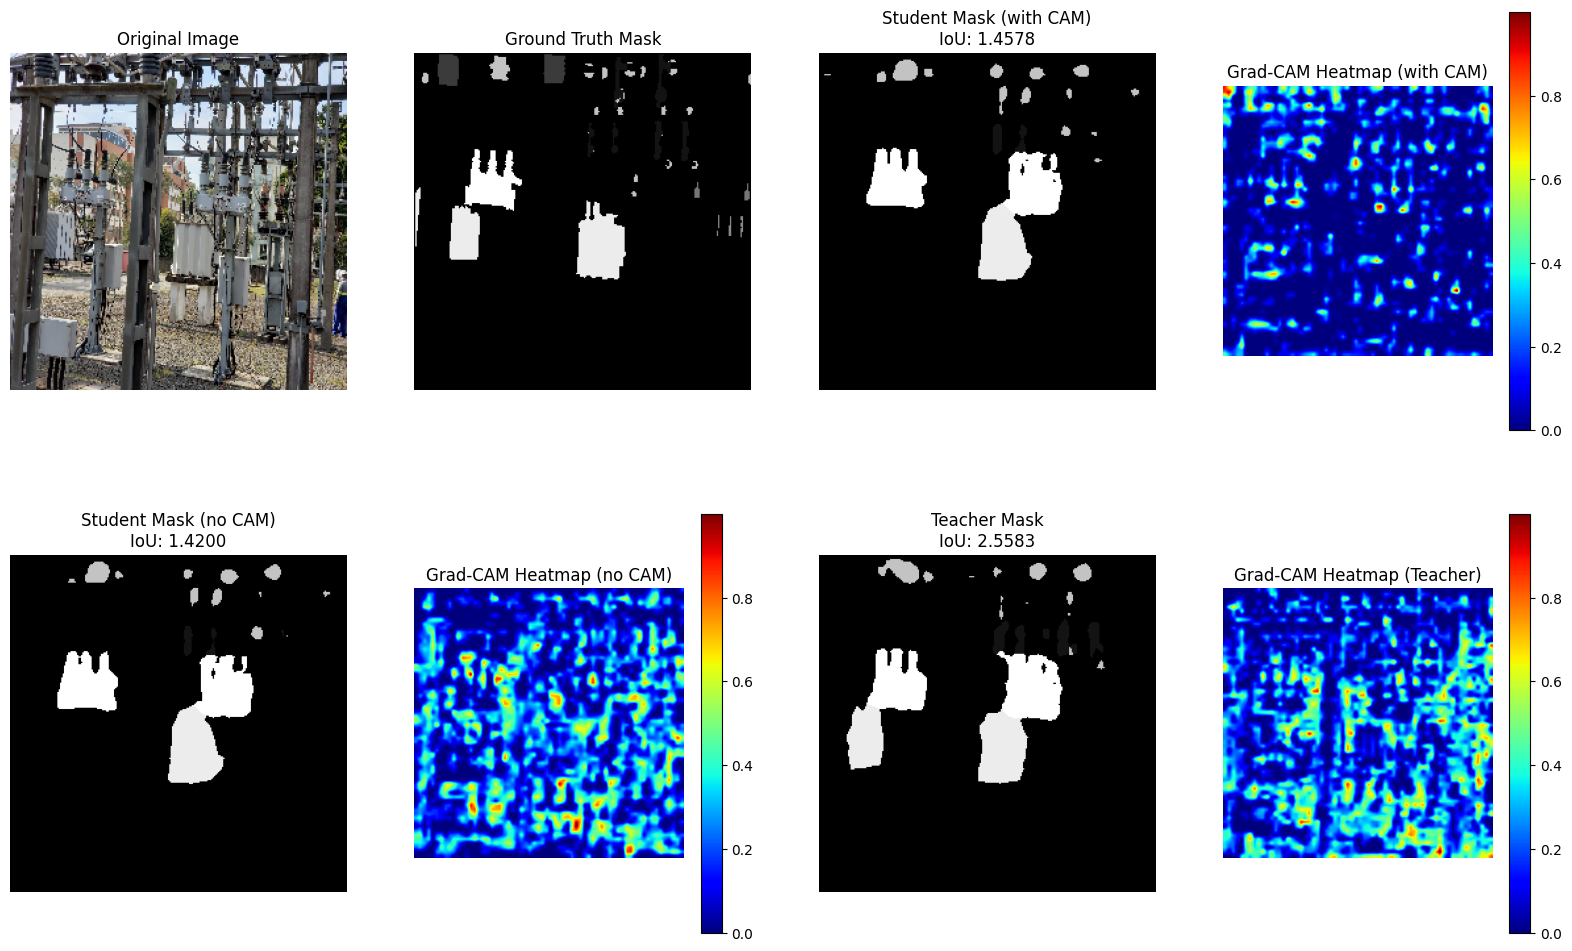

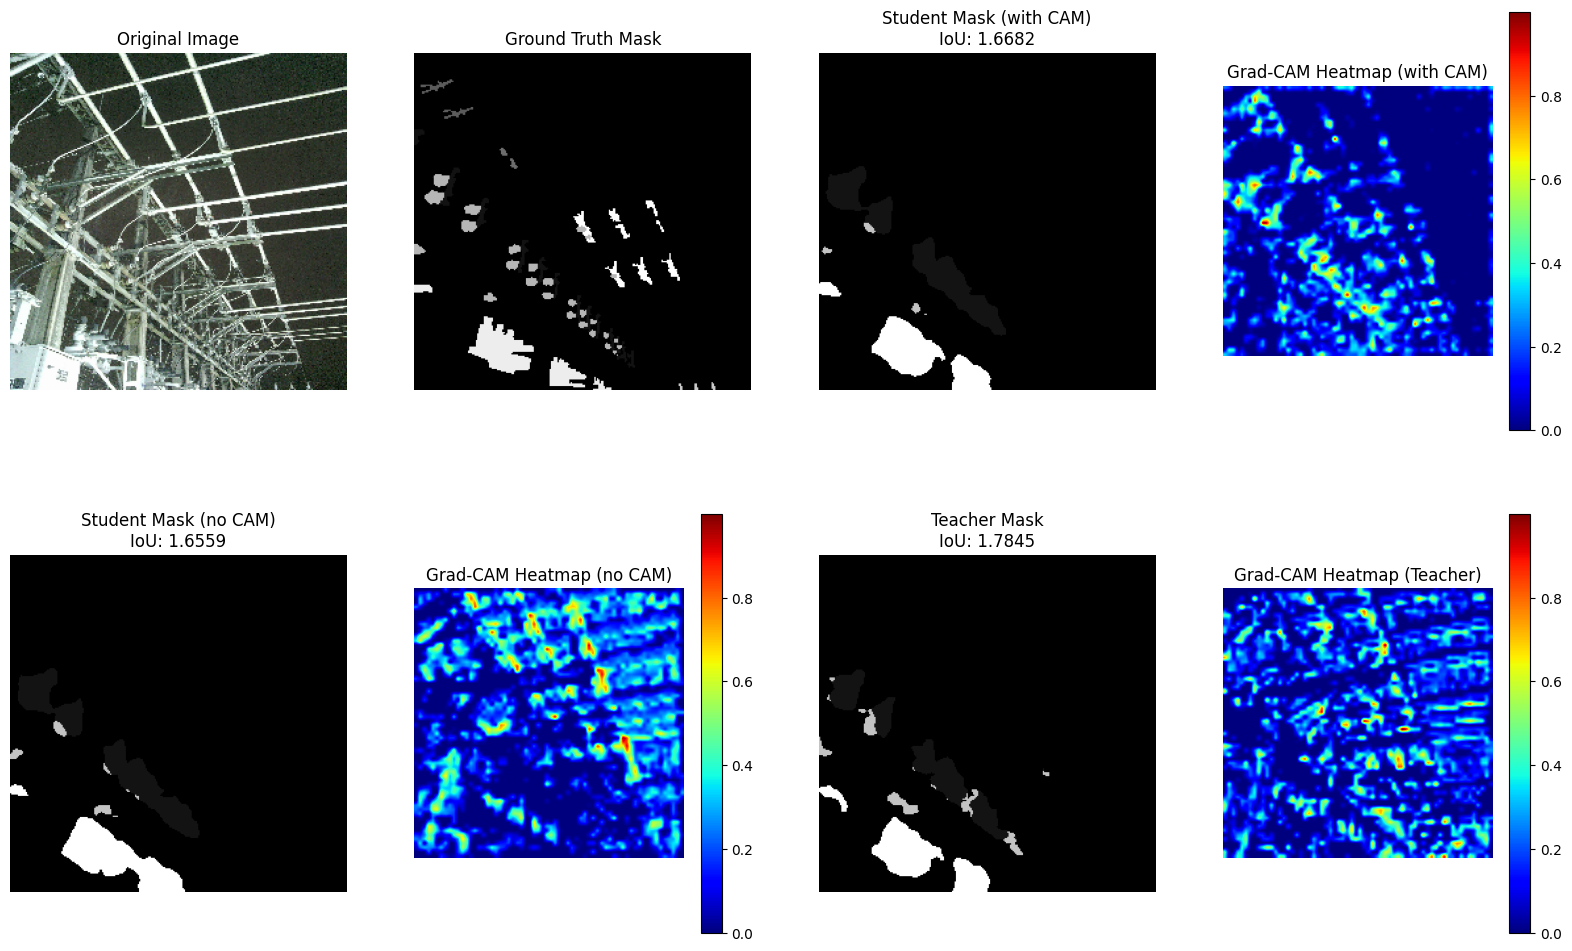

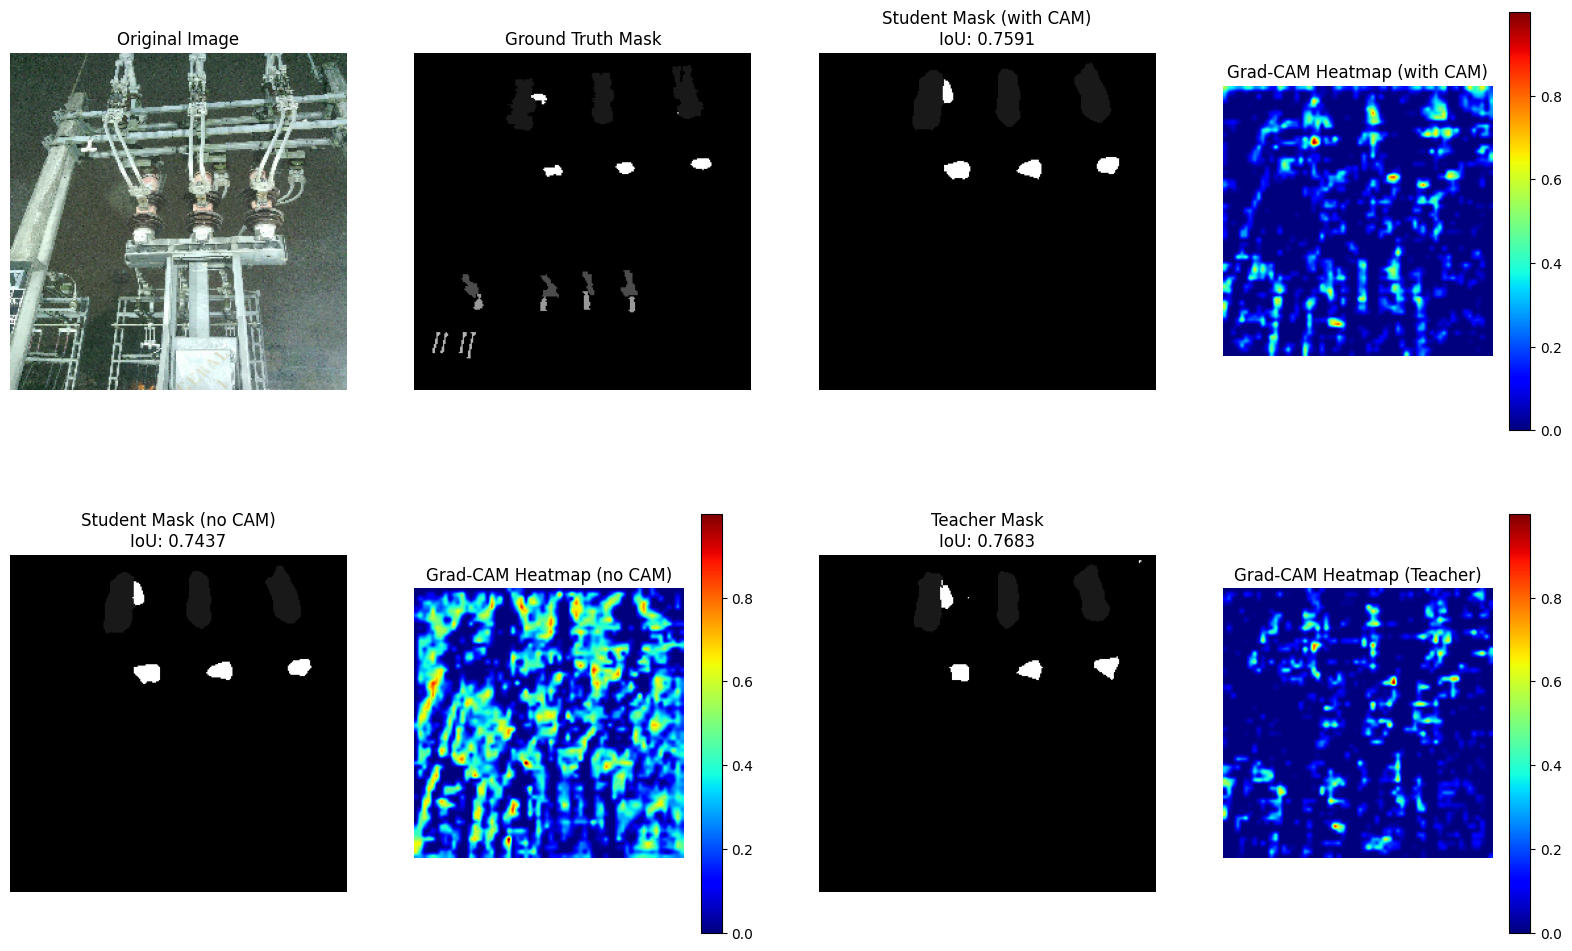

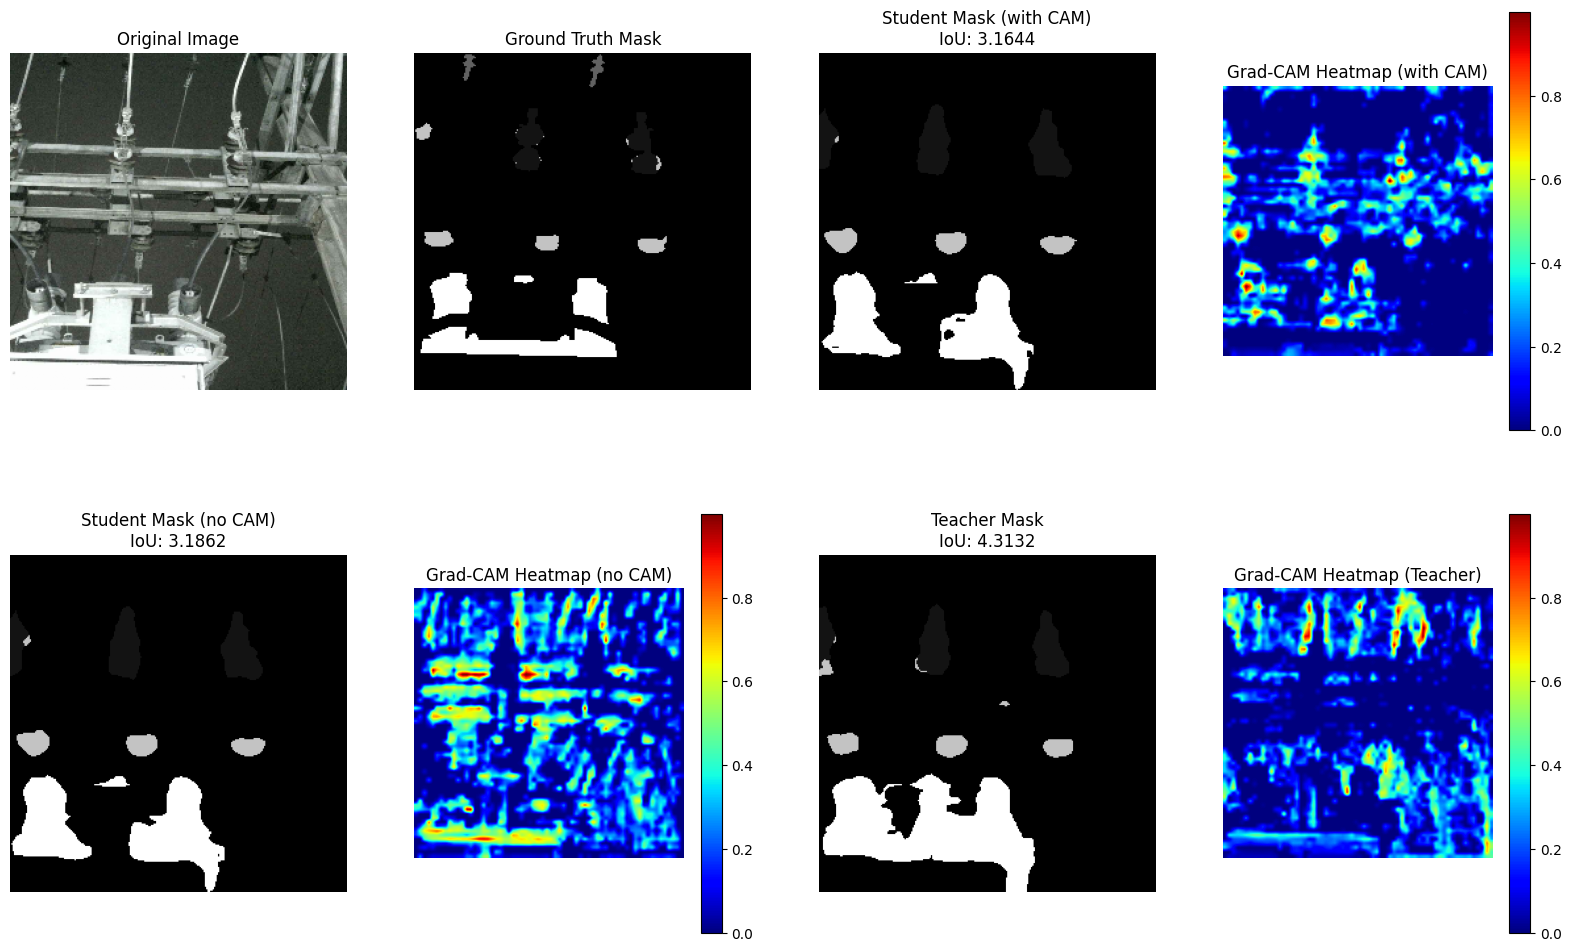

In [130]:
# Sample input
x_sample, y_sample = next(iter(val_loader))
x_sample = x_sample.to(DEVICE)
y_sample = y_sample.to(DEVICE)
x_sample.requires_grad = True  # Enable gradients for Grad-CAM if necessary

# Generate predictions and masks for all models
with torch.no_grad():
    student_output_cam = student_model_cam(x_sample)
    student_output_no_cam = student_model_no_cam(x_sample)
    teacher_output = teacher_model(x_sample)

# Generate masks by taking the argmax along the class dimension
student_masks_cam = torch.argmax(student_output_cam, dim=1, keepdim=True).float().squeeze(1)
student_masks_no_cam = torch.argmax(student_output_no_cam, dim=1, keepdim=True).float().squeeze(1)
teacher_masks = torch.argmax(teacher_output, dim=1, keepdim=True).float().squeeze(1)

# Compute IoU for each sample in the batch
iou_metric = IoU(threshold=0.5)
iou_cam = []
iou_no_cam = []
iou_teacher = []

for i in range(x_sample.size(0)):
    iou_cam.append(iou_metric(student_masks_cam[i].unsqueeze(0), y_sample[i].unsqueeze(0)).item())
    iou_no_cam.append(iou_metric(student_masks_no_cam[i].unsqueeze(0), y_sample[i].unsqueeze(0)).item())
    iou_teacher.append(iou_metric(teacher_masks[i].unsqueeze(0), y_sample[i].unsqueeze(0)).item())

# Compute Grad-CAM heatmaps for all models
student_heatmap_cam = compute_gradcam_heatmap(
    model=student_model_cam,
    target_layer=student_model_cam.decoder.block1,  # Adjust target layer if needed
    input_tensor=x_sample,
    masks=student_masks_cam
)

student_heatmap_no_cam = compute_gradcam_heatmap(
    model=student_model_no_cam,
    target_layer=student_model_no_cam.decoder.block1,  # Adjust target layer if needed
    input_tensor=x_sample,
    masks=student_masks_no_cam
)

teacher_heatmap = compute_gradcam_heatmap(
    model=teacher_model,
    target_layer=teacher_model.decoder.block1,  # Adjust target layer if needed
    input_tensor=x_sample,
    masks=teacher_masks
)

# Convert heatmaps to tensors
student_heatmap_cam = torch.from_numpy(student_heatmap_cam).float().to(DEVICE)
student_heatmap_no_cam = torch.from_numpy(student_heatmap_no_cam).float().to(DEVICE)
teacher_heatmap = torch.from_numpy(teacher_heatmap).float().to(DEVICE)


# Denormalize function (if input is normalized) for better visualization
def denormalize(image_tensor, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    image_tensor = image_tensor.clone().detach().cpu()
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)  # Denormalize each channel
    return image_tensor.clamp(0, 1)  # Clip to valid range


# Plot original image, ground truth mask, student mask, and Grad-CAM heatmap for all models, and display IoU
for i in range(min(10, x_sample.size(0))):  # Display up to 3 examples
    plt.figure(figsize=(20, 25))

    # Original image
    plt.subplot(4, 4, 1)
    original_image = denormalize(x_sample[i])
    plt.imshow(np.transpose(original_image.numpy(), (1, 2, 0)))  # Convert CHW to HWC
    plt.title("Original Image")
    plt.axis("off")

    # Ground truth mask
    plt.subplot(4, 4, 2)
    ground_truth_mask = y_sample[i].squeeze().cpu().numpy()  # Squeeze to remove the singleton dimension
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis("off")

    # Student mask with CAM
    plt.subplot(4, 4, 3)
    plt.imshow(student_masks_cam[i].cpu().numpy(), cmap='gray')
    plt.title(f"Student Mask (with CAM)\nIoU: {iou_cam[i]:.4f}")
    plt.axis("off")

    # Grad-CAM heatmap for student with CAM
    plt.subplot(4, 4, 4)
    plt.imshow(student_heatmap_cam[i].cpu().numpy(), cmap='jet')
    plt.title("Grad-CAM Heatmap (with CAM)")
    plt.colorbar()
    plt.axis("off")

    # Student mask without CAM
    plt.subplot(4, 4, 5)
    plt.imshow(student_masks_no_cam[i].cpu().numpy(), cmap='gray')
    plt.title(f"Student Mask (no CAM)\nIoU: {iou_no_cam[i]:.4f}")
    plt.axis("off")

    # Grad-CAM heatmap for student without CAM
    plt.subplot(4, 4, 6)
    plt.imshow(student_heatmap_no_cam[i].cpu().numpy(), cmap='jet')
    plt.title("Grad-CAM Heatmap (no CAM)")
    plt.colorbar()
    plt.axis("off")

    # Teacher mask
    plt.subplot(4, 4, 7)
    plt.imshow(teacher_masks[i].cpu().numpy(), cmap='gray')
    plt.title(f"Teacher Mask\nIoU: {iou_teacher[i]:.4f}")
    plt.axis("off")

    # Grad-CAM heatmap for teacher
    plt.subplot(4, 4, 8)
    plt.imshow(teacher_heatmap[i].cpu().numpy(), cmap='jet')
    plt.title("Grad-CAM Heatmap (Teacher)")
    plt.colorbar()
    plt.axis("off")

    plt.show()
